Pairs trading involves picking two stocks that are related in some way and profiting from the pricing differences between them. 

In [7]:
import math
import numpy as np
import matplotlib.pyplot  as plt
import yfinance as yf
import pytz
from datetime import datetime
import pandas as pd
from statsmodels.tsa.stattools import coint, adfuller
import seaborn as sns

tickers = [
    "KO", "PEP",
    "K", "GIS",
    "CPB", "KHC",
    "MDLZ", "HSY",
    "SJM", "KMB",
    "PG", "CL",
    "WMT", "COST",
    "TGT"
]
data = yf.download(tickers, start='2022-01-01', end='2025-01-01')

prices = data['Close']

print(prices)

/tmp/ipykernel_888/1629220069.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2022-01-01', end='2025-01-01')
[*********************100%***********************]  15 of 15 completed

Ticker             CL        COST        CPB        GIS         HSY  \
Date                                                                  
2022-01-03  76.912788  540.298523  38.054550  58.529991  175.015518   
2022-01-04  77.167389  537.934021  38.385155  59.078213  176.510071   
2022-01-05  77.485603  524.291077  38.850166  59.870102  178.448593   
2022-01-06  76.976440  524.176514  39.508190  59.600346  178.059128   
2022-01-07  76.776405  511.191284  40.227638  60.117615  177.406891   
...               ...         ...        ...        ...         ...   
2024-12-24  90.208801  953.842712  39.853218  60.951340  165.077072   
2024-12-26  90.189285  951.176636  39.929787  60.970463  164.776901   
2024-12-27  89.642502  934.821960  40.015926  61.152149  166.306747   
2024-12-30  88.646576  917.422791  39.642654  60.597527  163.314835   
2024-12-31  88.763748  911.513611  40.082924  60.980030  163.973267   

Ticker              K        KHC         KMB         KO       MDLZ  \
Date  

[('KHC', 'TGT'), ('KMB', 'KO')]


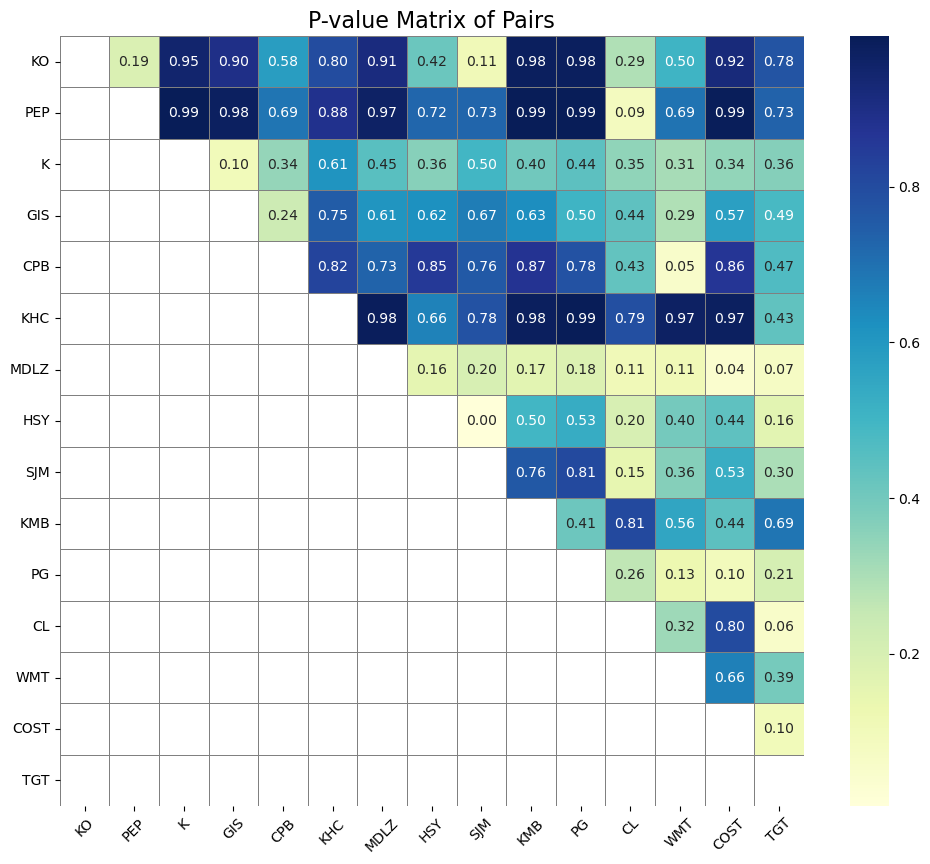

In [8]:
# start by running a cointegration test between chosen list of stocks/securities

def find_cointegrated_pairs(data):
    n = data.shape[1]
    # print(n)
    keys = data.keys()
    # print(keys)
    pvalue_matrix = np.ones((n, n))
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            s1 = data[keys[i]]
            s2 = data[keys[j]]
            coint_val, p_val, _ = coint(s1, s2)
            pvalue_matrix[i, j] = p_val
            if p_val < 0.05:
                pairs.append((keys[i], keys[j]))
    return pairs, pvalue_matrix
    

res, pvalue_matrix = find_cointegrated_pairs(prices)
print(res)

def plot_p_val_matrix(p_val_matrix, tickers):
    # Make a mask for the upper triangle
    mask = np.tril(np.ones_like(p_val_matrix, dtype=bool))
    
    plt.figure(figsize=(12,10))
    
    # Custom colormap: yellow → green → blue
    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    
    sns.heatmap(
        p_val_matrix,
        mask=mask,               # mask upper triangle
        annot=True,
        fmt=".2f",
        cmap=cmap,
        cbar=True,
        xticklabels=tickers,
        yticklabels=tickers,
        linewidths=0.5,
        linecolor='gray'
    )
    
    plt.title("P-value Matrix of Pairs", fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_p_val_matrix(pvalue_matrix, tickers)

In [9]:
# stationarity test
def stationarity_test(x, cutoff=0.05):
    # H_0: non stationarity
    # H_1: low enough p val for stationarity
    pvalue = adfuller(x)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + x.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + x.name +' is likely non-stationary.')
        

# get stocks that are cointegrated and add them all to a set:

def test_stationarity_on_cointegrated_pairs(coint_pairs, data):
    for coint_pair in coint_pairs:
        s1 = data[coint_pair[0]]
        s2 = data[coint_pair[1]]
        stationarity_test(s1)
        stationarity_test(s2)
        print()

test_stationarity_on_cointegrated_pairs(res, prices)
        

p-value = 0.041785523687022964 The series KHC is likely stationary.
p-value = 0.03657303981270024 The series TGT is likely stationary.

p-value = 0.23019236878140964 The series KMB is likely non-stationary.
p-value = 0.28594493788120456 The series KO is likely non-stationary.

